In [40]:
from pandas_datareader import data as pdr
import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [41]:
#define models for later use

def rnn_model():
    rnn = keras.Sequential()
    rnn.add(keras.layers.SimpleRNN(128, return_sequences=True))
    rnn.add(keras.layers.SimpleRNN(128, return_sequences=True))
    rnn.add(keras.layers.SimpleRNN(256, return_sequences=True))
    rnn.add(keras.layers.SimpleRNN(32))
    rnn.add(keras.layers.Dense(units = 1))

    rnn.compile(optimizer='rmsprop', loss='mean_squared_error')
    rnn.fit(X_train, y_train, epochs=100, batch_size=32)
    predicted_rnn = rnn.predict(X_test)
    #un-normalize
    predicted_rnn = sc.inverse_transform(predicted_rnn)
    return predicted_rnn


def lstm_model():
    lstm = keras.Sequential()
    lstm.add(keras.layers.LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    lstm.add(keras.layers.Dropout(rate = 0.2))
    lstm.add(keras.layers.LSTM(units = 50, return_sequences = True))
    lstm.add(keras.layers.Dropout(rate = 0.2))
    lstm.add(keras.layers.LSTM(units = 50, return_sequences = True))
    lstm.add(keras.layers.Dropout(rate = 0.2))
    lstm.add(keras.layers.LSTM(units = 50, return_sequences = False))
    lstm.add(keras.layers.Dropout(rate = 0.2))
    lstm.add(keras.layers.Dense(units = 1))

    lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')
    lstm.fit(x = X_train, y = y_train, batch_size = 32, epochs = 100)
    predicted_lstm = lstm.predict(X_test)
    #un-normalize
    predicted_lstm = sc.inverse_transform(predicted_lstm)
    return predicted_lstm


def gru_model():
    gru = keras.Sequential()
    gru.add(keras.layers.GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    gru.add(keras.layers.GRU(units=50, return_sequences=True))
    gru.add(keras.layers.GRU(units=50, return_sequences=True))
    gru.add(keras.layers.GRU(units=50, return_sequences=False, activation='tanh'))
    gru.add(keras.layers.Dense(units=1))

    history = gru.compile(optimizer='rmsprop', loss='mean_squared_error')
    gru.fit(X_train, y_train, batch_size = 32, epochs = 100)
    predicted_gru = gru.predict(X_test)
    #un-normalize
    predicted_gru = sc.inverse_transform(predicted_gru)
    return predicted_gru

Alphabet Forecasts

In [42]:
yf.pdr_override()

# download dataframe
df = pdr.get_data_yahoo("ABC", start="2020-10-15", end="2022-10-03", interval='60m')

#drop unneeded data
data = df.iloc[:, 0: 1].values

#create standardization parameters
sc = MinMaxScaler(feature_range = (0, 1))

#standardize data
data = sc.fit_transform(data)

#create blank lists for X and y values
X = []
y  = []

#arrange data for use case
#use the previous 60 time steps to predict the next step
for i in range(60, len(data)): # in the range from the 61st value to the end
    X.append(data[i-60: i, 0]) # load the previous 60 values into x
    y.append(data[i, 0]) # load the current value into y

#convert lists to numpy arrays
X, y = np.array(X), np.array(y)

#split training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .02, random_state = 42)

#reshape data to fit model inputs
X_train = np.reshape(X_train, newshape = (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, newshape = (X_test.shape[0], X_test.shape[1], 1))


[*********************100%***********************]  1 of 1 completed


In [43]:
predicted_rnn = rnn_model()
predicted_lstm = lstm_model()
predicted_gru = gru_model()

Epoch 1/100
104/104 [==============================] - 5s 35ms/step - loss: 0.1847
Epoch 2/100
104/104 [==============================] - 4s 35ms/step - loss: 0.0494
Epoch 3/100
104/104 [==============================] - 4s 35ms/step - loss: 0.0499
Epoch 4/100
104/104 [==============================] - 4s 35ms/step - loss: 0.0290
Epoch 5/100
104/104 [==============================] - 4s 35ms/step - loss: 0.0158
Epoch 6/100
104/104 [==============================] - 4s 35ms/step - loss: 0.0111
Epoch 7/100
104/104 [==============================] - 4s 35ms/step - loss: 0.0091
Epoch 8/100
104/104 [==============================] - 4s 35ms/step - loss: 0.0076
Epoch 9/100
104/104 [==============================] - 4s 35ms/step - loss: 0.0079
Epoch 10/100
104/104 [==============================] - 4s 35ms/step - loss: 0.0083
Epoch 11/100
104/104 [==============================] - 4s 35ms/step - loss: 0.0067
Epoch 12/100
104/104 [==============================] - 4s 35ms/step - loss: 0.0059
E

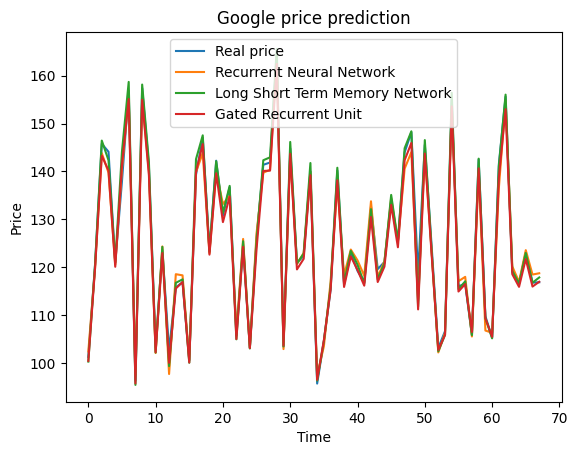

In [44]:
#un-normalize y test values
org = sc.inverse_transform(y_test.reshape(-1, 1))

#plot the predictions and the original data in the same line graph
plt.plot(org, label = 'Real price')
plt.plot(predicted_rnn, label = 'Recurrent Neural Network')
plt.plot(predicted_lstm, label = 'Long Short Term Memory Network')
plt.plot(predicted_gru, label = 'Gated Recurrent Unit')
plt.title('Google price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

Test RMSE - RNN: 1.956
Test RMSE - LSTM: 1.469
Test RMSE - GRU: 1.739


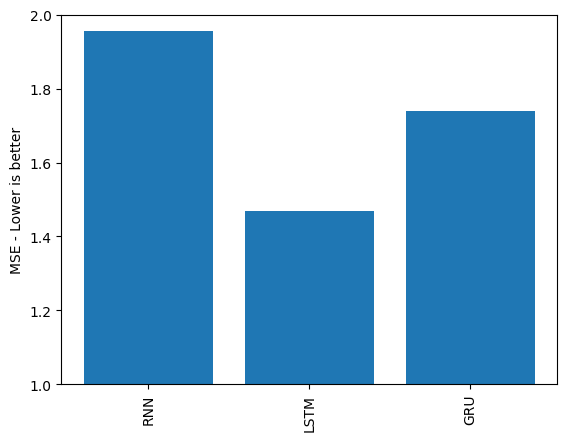

In [47]:
#create a blank dict to load values into
model_accuracy = {}

#get MSE of each model and load into dict
rmse_rnn = np.sqrt(mean_squared_error(org, predicted_rnn))
model_accuracy.update({"RNN": rmse_rnn})

rmse_lstm = np.sqrt(mean_squared_error(org, predicted_lstm))
model_accuracy.update({"LSTM": rmse_lstm})

rmse_gru = np.sqrt(mean_squared_error(org, predicted_gru))
model_accuracy.update({"GRU": rmse_gru})

#show the values
print ('Test RMSE - RNN: %.3f' % rmse_rnn)
print ('Test RMSE - LSTM: %.3f' % rmse_lstm)
print ('Test RMSE - GRU: %.3f' % rmse_gru)

#convert the dict into 2 lists
model_type = list(model_accuracy.keys())
model_acc = list(model_accuracy.values())

#plot the lists
plt.bar(range(len(model_accuracy)), model_acc, tick_label=model_type)
#scale the plot
plt.ylim(1, 2)
plt.ylabel("MSE - Lower is better")
#rotate the x-axis labels for readability
plt.xticks(rotation = 90)
plt.show()

Amazon Forecasts

In [48]:
yf.pdr_override()

# download dataframe
df = pdr.get_data_yahoo("AMZN", start="2020-10-15", end="2022-10-03", interval='60m')

#drop unneeded data
data = df.iloc[:, 0: 1].values

#create standardization parameters
sc = MinMaxScaler(feature_range = (0, 1))

#standardize data
data = sc.fit_transform(data)

#create blank lists for X and y values
X = []
y  = []

#arrange data for use case
#use the previous 60 time steps to predict the next step
for i in range(60, len(data)): # in the range from the 61st value to the end
    X.append(data[i-60: i, 0]) # load the previous 60 values into x
    y.append(data[i, 0]) # load the current value into y

#convert lists to numpy arrays
X, y = np.array(X), np.array(y)

#split training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .02, random_state = 42)

#reshape data to fit model inputs
X_train = np.reshape(X_train, newshape = (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, newshape = (X_test.shape[0], X_test.shape[1], 1))


[*********************100%***********************]  1 of 1 completed


In [49]:
predicted_rnn = rnn_model()
predicted_lstm = lstm_model()
predicted_gru = gru_model()

Epoch 1/100
104/104 [==============================] - 5s 39ms/step - loss: 0.1907
Epoch 2/100
104/104 [==============================] - 4s 39ms/step - loss: 0.3001
Epoch 3/100
104/104 [==============================] - 4s 39ms/step - loss: 0.4687
Epoch 4/100
104/104 [==============================] - 4s 39ms/step - loss: 0.2124
Epoch 5/100
104/104 [==============================] - 4s 39ms/step - loss: 0.1546
Epoch 6/100
104/104 [==============================] - 4s 39ms/step - loss: 0.0943
Epoch 7/100
104/104 [==============================] - 4s 39ms/step - loss: 0.0615
Epoch 8/100
104/104 [==============================] - 4s 39ms/step - loss: 0.0392
Epoch 9/100
104/104 [==============================] - 4s 39ms/step - loss: 0.0532
Epoch 10/100
104/104 [==============================] - 4s 39ms/step - loss: 0.0138
Epoch 11/100
104/104 [==============================] - 4s 39ms/step - loss: 0.0313
Epoch 12/100
104/104 [==============================] - 4s 39ms/step - loss: 0.0178
E

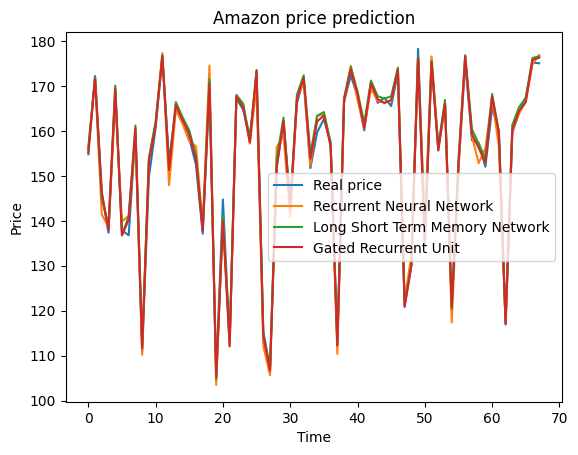

In [50]:
org = sc.inverse_transform(y_test.reshape(-1, 1))

plt.plot(org, label = 'Real price')
plt.plot(predicted_rnn, label = 'Recurrent Neural Network')
plt.plot(predicted_lstm, label = 'Long Short Term Memory Network')
plt.plot(predicted_gru, label = 'Gated Recurrent Unit')
plt.title('Amazon price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

Test RMSE - RNN: 2.290
Test RMSE - LSTM: 1.619
Test RMSE - GRU: 1.309


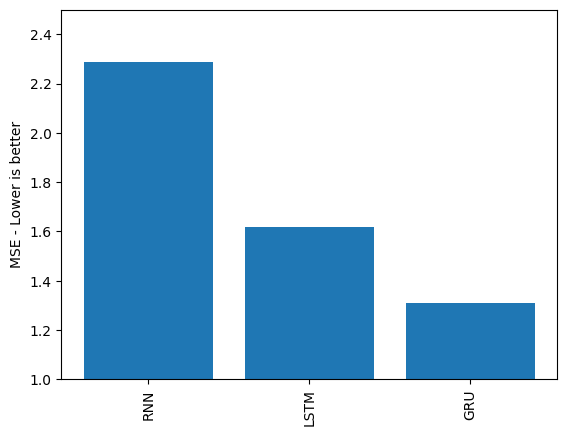

In [52]:
#create a blank dict to load values into
model_accuracy = {}

#get MSE of each model and load into dict
rmse_rnn = np.sqrt(mean_squared_error(org, predicted_rnn))
model_accuracy.update({"RNN": rmse_rnn})

rmse_lstm = np.sqrt(mean_squared_error(org, predicted_lstm))
model_accuracy.update({"LSTM": rmse_lstm})

rmse_gru = np.sqrt(mean_squared_error(org, predicted_gru))
model_accuracy.update({"GRU": rmse_gru})

#show the values
print ('Test RMSE - RNN: %.3f' % rmse_rnn)
print ('Test RMSE - LSTM: %.3f' % rmse_lstm)
print ('Test RMSE - GRU: %.3f' % rmse_gru)

#convert the dict into 2 lists
model_type = list(model_accuracy.keys())
model_acc = list(model_accuracy.values())

#plot the lists
plt.bar(range(len(model_accuracy)), model_acc, tick_label=model_type)
#scale the plot
plt.ylim(1, 2.5)
plt.ylabel("MSE - Lower is better")
#rotate the x-axis labels for readability
plt.xticks(rotation = 90)
plt.show()

Tesla Forecasts

In [53]:
yf.pdr_override()

# download dataframe
df = pdr.get_data_yahoo("TSLA", start="2020-10-15", end="2022-10-03", interval='60m')

#drop unneeded data
data = df.iloc[:, 0: 1].values

#create standardization parameters
sc = MinMaxScaler(feature_range = (0, 1))

#standardize data
data = sc.fit_transform(data)

#create blank lists for X and y values
X = []
y  = []

#arrange data for use case
#use the previous 60 time steps to predict the next step
for i in range(60, len(data)): # in the range from the 61st value to the end
    X.append(data[i-60: i, 0]) # load the previous 60 values into x
    y.append(data[i, 0]) # load the current value into y

#convert lists to numpy arrays
X, y = np.array(X), np.array(y)

#split training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .02, random_state = 42)

#reshape data to fit model inputs
X_train = np.reshape(X_train, newshape = (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, newshape = (X_test.shape[0], X_test.shape[1], 1))

[*********************100%***********************]  1 of 1 completed


In [54]:
predicted_rnn = rnn_model()
predicted_lstm = lstm_model()
predicted_gru = gru_model()

Epoch 1/100
104/104 [==============================] - 5s 36ms/step - loss: 0.2279
Epoch 2/100
104/104 [==============================] - 4s 36ms/step - loss: 0.0430
Epoch 3/100
104/104 [==============================] - 4s 36ms/step - loss: 0.0428
Epoch 4/100
104/104 [==============================] - 4s 36ms/step - loss: 0.0521
Epoch 5/100
104/104 [==============================] - 4s 36ms/step - loss: 0.1661
Epoch 6/100
104/104 [==============================] - 4s 36ms/step - loss: 0.2120
Epoch 7/100
104/104 [==============================] - 4s 36ms/step - loss: 0.0889
Epoch 8/100
104/104 [==============================] - 4s 36ms/step - loss: 0.0926
Epoch 9/100
104/104 [==============================] - 4s 36ms/step - loss: 0.0547
Epoch 10/100
104/104 [==============================] - 4s 36ms/step - loss: 0.0502
Epoch 11/100
104/104 [==============================] - 4s 36ms/step - loss: 0.0768
Epoch 12/100
104/104 [==============================] - 4s 36ms/step - loss: 0.0440
E

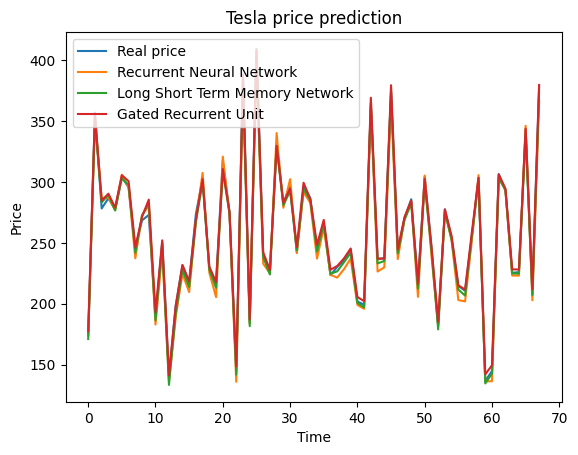

In [55]:
org = sc.inverse_transform(y_test.reshape(-1, 1))

plt.plot(org, label = 'Real price')
plt.plot(predicted_rnn, label = 'Recurrent Neural Network')
plt.plot(predicted_lstm, label = 'Long Short Term Memory Network')
plt.plot(predicted_gru, label = 'Gated Recurrent Unit')
plt.title('Tesla price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

Test RMSE - RNN: 6.117
Test RMSE - LSTM: 3.657
Test RMSE - GRU: 3.116


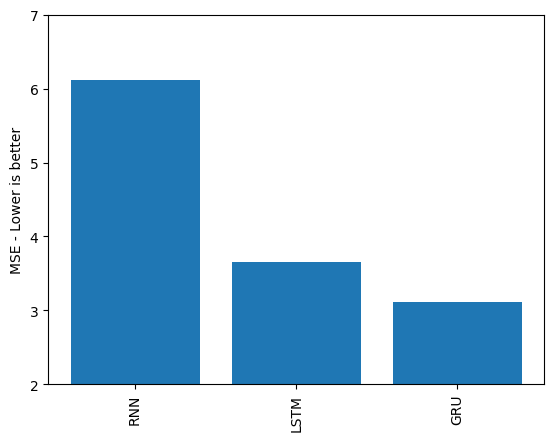

In [57]:
#create a blank dict to load values into
model_accuracy = {}

#get MSE of each model and load into dict
rmse_rnn = np.sqrt(mean_squared_error(org, predicted_rnn))
model_accuracy.update({"RNN": rmse_rnn})

rmse_lstm = np.sqrt(mean_squared_error(org, predicted_lstm))
model_accuracy.update({"LSTM": rmse_lstm})

rmse_gru = np.sqrt(mean_squared_error(org, predicted_gru))
model_accuracy.update({"GRU": rmse_gru})

#show the values
print ('Test RMSE - RNN: %.3f' % rmse_rnn)
print ('Test RMSE - LSTM: %.3f' % rmse_lstm)
print ('Test RMSE - GRU: %.3f' % rmse_gru)

#convert the dict into 2 lists
model_type = list(model_accuracy.keys())
model_acc = list(model_accuracy.values())

#plot the lists
plt.bar(range(len(model_accuracy)), model_acc, tick_label=model_type)
#scale the plot
plt.ylim(2, 7)
plt.ylabel("MSE - Lower is better")
#rotate the x-axis labels for readability
plt.xticks(rotation = 90)
plt.show()